This notebook is part of [**Byron v0.8**](https://pypi.org/project/byron/)  
Copyright 2023-24 Giovanni Squillero and Alberto Tonda  
SPDX-License-Identifier: [Apache-2.0](https://www.apache.org/licenses/LICENSE-2.0) 

In [1]:
import byron

/var/folders/31/dkl97hks2c14b663vl55pt440000gn/T/ipykernel_19770/1429530752.py:1: ByronPerformanceWarning: 
  Paranoia checks are enabled in this notebook: performances can be significantly impaired
  [see https://cad-polito-it.github.io/byron/paranoia for details]
  import byron


# Assembly Tutorial

Oversimplified assembler vaguely based on x86 assembly 

## Framework

Known as *Instruction Library* in MicroGP2 and *constraints* in MicroGP3

### Operands: Registers and Immediate 

In [2]:
reg8 = byron.f.choice_parameter(['ah', 'bh', 'ch', 'dh', 'al', 'bl', 'cl', 'dl'])
reg16 = byron.f.choice_parameter(['ax', 'bx', 'cx', 'dx'])
int8 = byron.f.integer_parameter(0, 2 ** 8)
int16 = byron.f.integer_parameter(0, 2 ** 16)

### Operands: Registers and Immediate

See https://docs.python.org/3/library/string.html#formatspec for the format specification

In [3]:
opcodes2 = byron.f.choice_parameter(['mov', 'add', 'sub', 'or', 'and'])
opcodes1 = byron.f.choice_parameter(['not', 'neg', 'inc', 'dec'])
opcodes0 = byron.f.choice_parameter(['nop', 'hlt'])

inst8rr = byron.f.macro("{op} {r1}, {r2}", op=opcodes2, r1=reg8, r2=reg8)
inst8ri = byron.f.macro("{op} {r}, {i:#x}", op=opcodes2, r=reg8, i=int8)
inst8r = byron.f.macro("{op} {r}", op=opcodes1, r=reg8)

inst16rr = byron.f.macro("{op} {r1}, {r2}", op=opcodes2, r1=reg16, r2=reg16)
inst16ri = byron.f.macro("{op} {r}, {i:#x}", op=opcodes2, r=reg16, i=int16)
inst16r = byron.f.macro("{op} {r}", op=opcodes1, r=reg16)

### A simple fragment of code

In [4]:
prog = byron.f.bunch([inst16rr, inst16ri, inst16r, inst8rr, inst8ri, inst8r], 5)
byron.f.as_text(prog)


; 🖋 n1 ➜ Frame❬MacroArray#1❭
and ax, ax  ; 🖋 n1.n2 ➜ Macro❬User#4❭
not ah  ; 🖋 n1.n3 ➜ Macro❬User#3❭
dec ax  ; 🖋 n1.n4 ➜ Macro❬User#6❭
and ax, 0x6ff1  ; 🖋 n1.n5 ➜ Macro❬User#5❭
sub dx, 0x65ce  ; 🖋 n1.n6 ➜ Macro❬User#5❭



### Add conditional branches (local references)

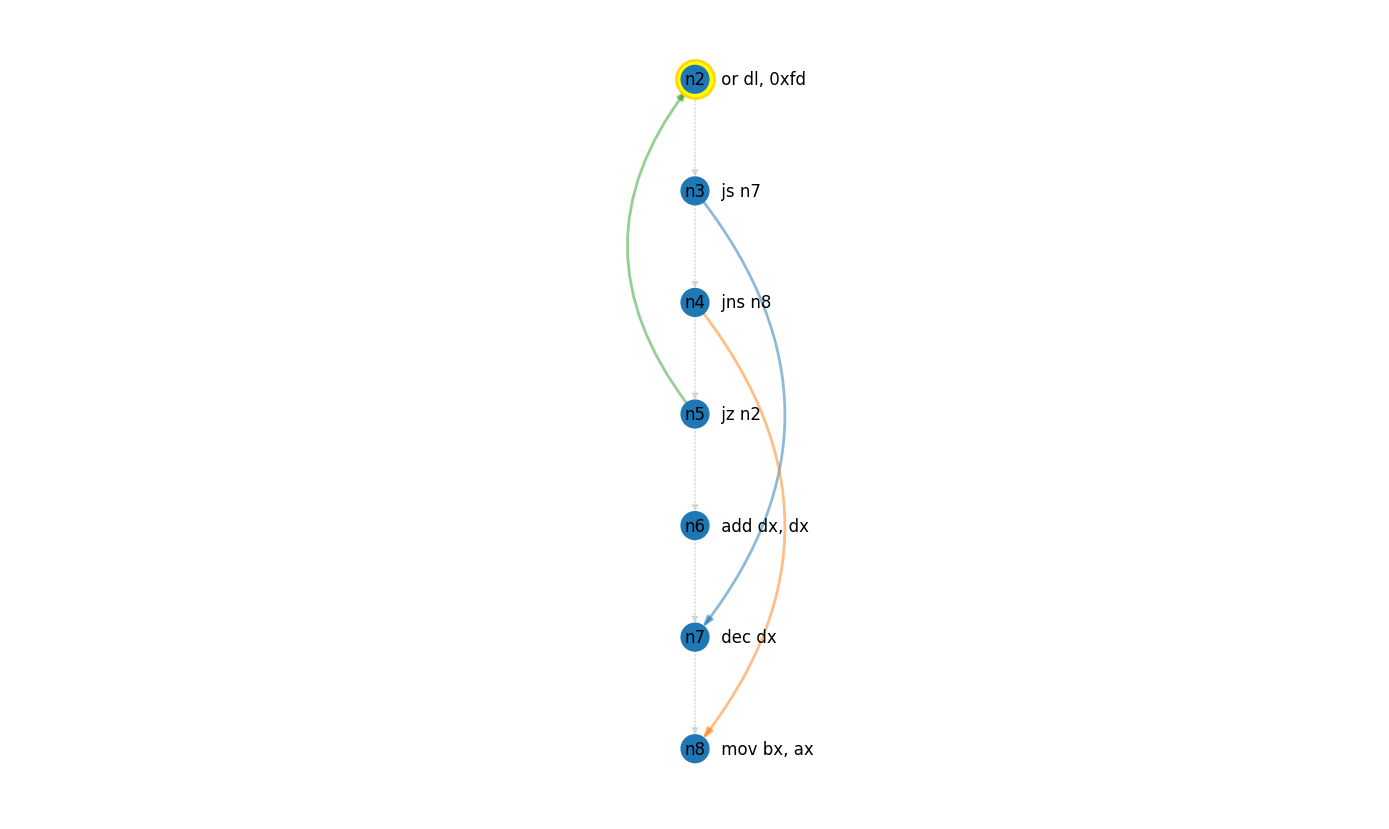

In [5]:
tests = byron.f.choice_parameter(['jz', 'jnz', 'jc', 'jnc', 'jo', 'jno', 'js', 'jns'])
branch = byron.f.macro("{test} {label}", test=tests, label=byron.f.local_reference())
prog = byron.f.bunch([inst16rr, inst16ri, inst16r, inst8rr, inst8ri, inst8r, branch], 7)

byron.f.as_lgp(prog, seed=1)

### Let's add subroutines

In [6]:
sub_entry = byron.f.macro("\nproc {_node} near", _label='')
sub_exit = byron.f.macro("ret")
sub_body = byron.f.bunch([inst16rr, inst16ri, inst16r, inst8rr, inst8ri, inst8r], 3)
sub = byron.f.sequence([sub_entry, sub_body, sub_exit])

call = byron.f.macro("call {proc}", proc=byron.f.global_reference(sub, first_macro=True, creative_zeal=1))

Create a full program with header, initialization, and main body. Just for testing purpose, let "calls" be more frequent than the other instructions (62.5% of macros in `main_body` will be `call`). 

In [7]:
main_prologue = """section .text

global _start
_start:
"""

test_main_body = byron.f.bunch([inst16rr, inst16ri, inst16r, inst8rr, inst8ri, inst8r, branch, call],
                               size=10, weights=[1, 1, 1, 1, 1, 1, 1, 10])
init = byron.f.macro("mov ax, {v:#x}\nmov bx, {v:#x}\nmov cx, {v:#x}\nmov dx, {v:#x}", v=int16)

full_prog = byron.f.sequence([main_prologue, init, test_main_body])

In [8]:
byron.f.as_text(full_prog, seed=2)

; 🖋 n23 ➜ Frame❬FrameSequence#2❭
section .text

global _start
_start:
  ; 🖋 n23.n24 ➜ Macro❬Text#3❭
mov ax, 0xc97d
mov bx, 0xc97d
mov cx, 0xc97d
mov dx, 0xc97d  ; 🖋 n23.n25 ➜ Macro❬User#9❭
; 🖋 n23.n26 ➜ Frame❬MacroArray#4❭
neg dx  ; 🖋 n23.n26.n27 ➜ Macro❬User#6❭
neg ax  ; 🖋 n23.n26.n28 ➜ Macro❬User#6❭
call n38  ; 🖋 n23.n26.n29 ➜ Macro❬User#8❭
inc cl  ; 🖋 n23.n26.n30 ➜ Macro❬User#3❭
n31:
call n38  ; 🖋 n23.n26.n31 ➜ Macro❬User#8❭
call n45  ; 🖋 n23.n26.n32 ➜ Macro❬User#8❭
jz n31  ; 🖋 n23.n26.n33 ➜ Macro❬User#7❭
or dx, 0xb535  ; 🖋 n23.n26.n34 ➜ Macro❬User#5❭
neg dl  ; 🖋 n23.n26.n35 ➜ Macro❬User#3❭
call n45  ; 🖋 n23.n26.n36 ➜ Macro❬User#8❭
; 🖋 n37 ➜ Frame❬FrameSequence#1❭

proc n38 near  ; 🖋 n37.n38 ➜ Macro❬Text#1❭
; 🖋 n37.n39 ➜ Frame❬MacroArray#3❭
or bh, bh  ; 🖋 n37.n39.n40 ➜ Macro❬User#1❭
inc bx  ; 🖋 n37.n39.n41 ➜ Macro❬User#6❭
add bh, cl  ; 🖋 n37.n39.n42 ➜ Macro❬User#1❭
ret  ; 🖋 n37.n43 ➜ Macro❬Text#2❭
; 🖋 n44 ➜ Frame❬FrameSequence#1❭

proc n45 near  ; 🖋 n44.n45 ➜ Macro❬Text#1❭
; 🖋 n44.n

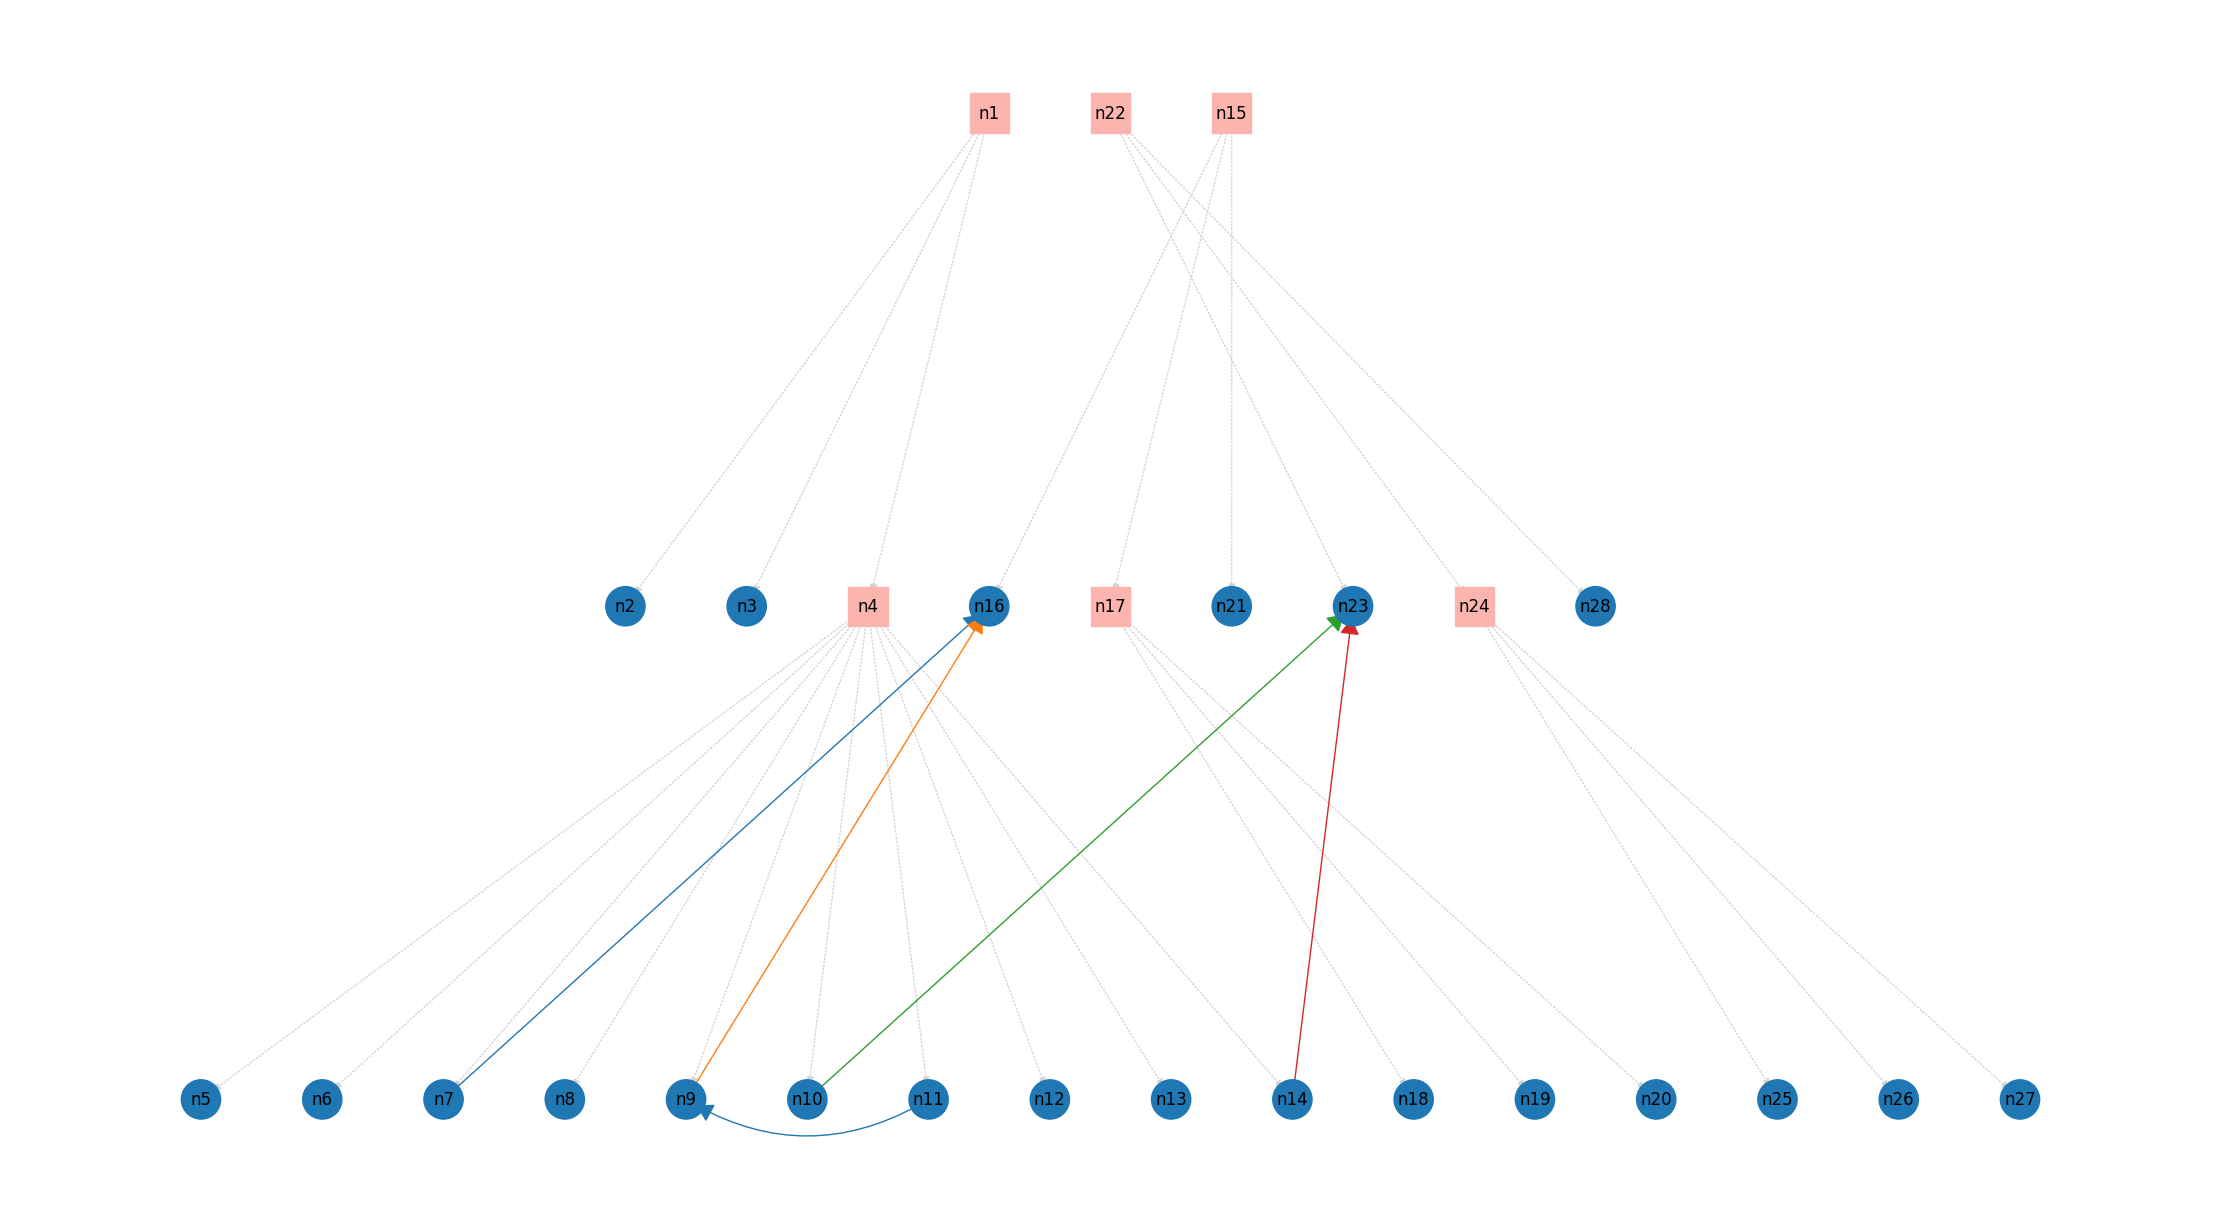

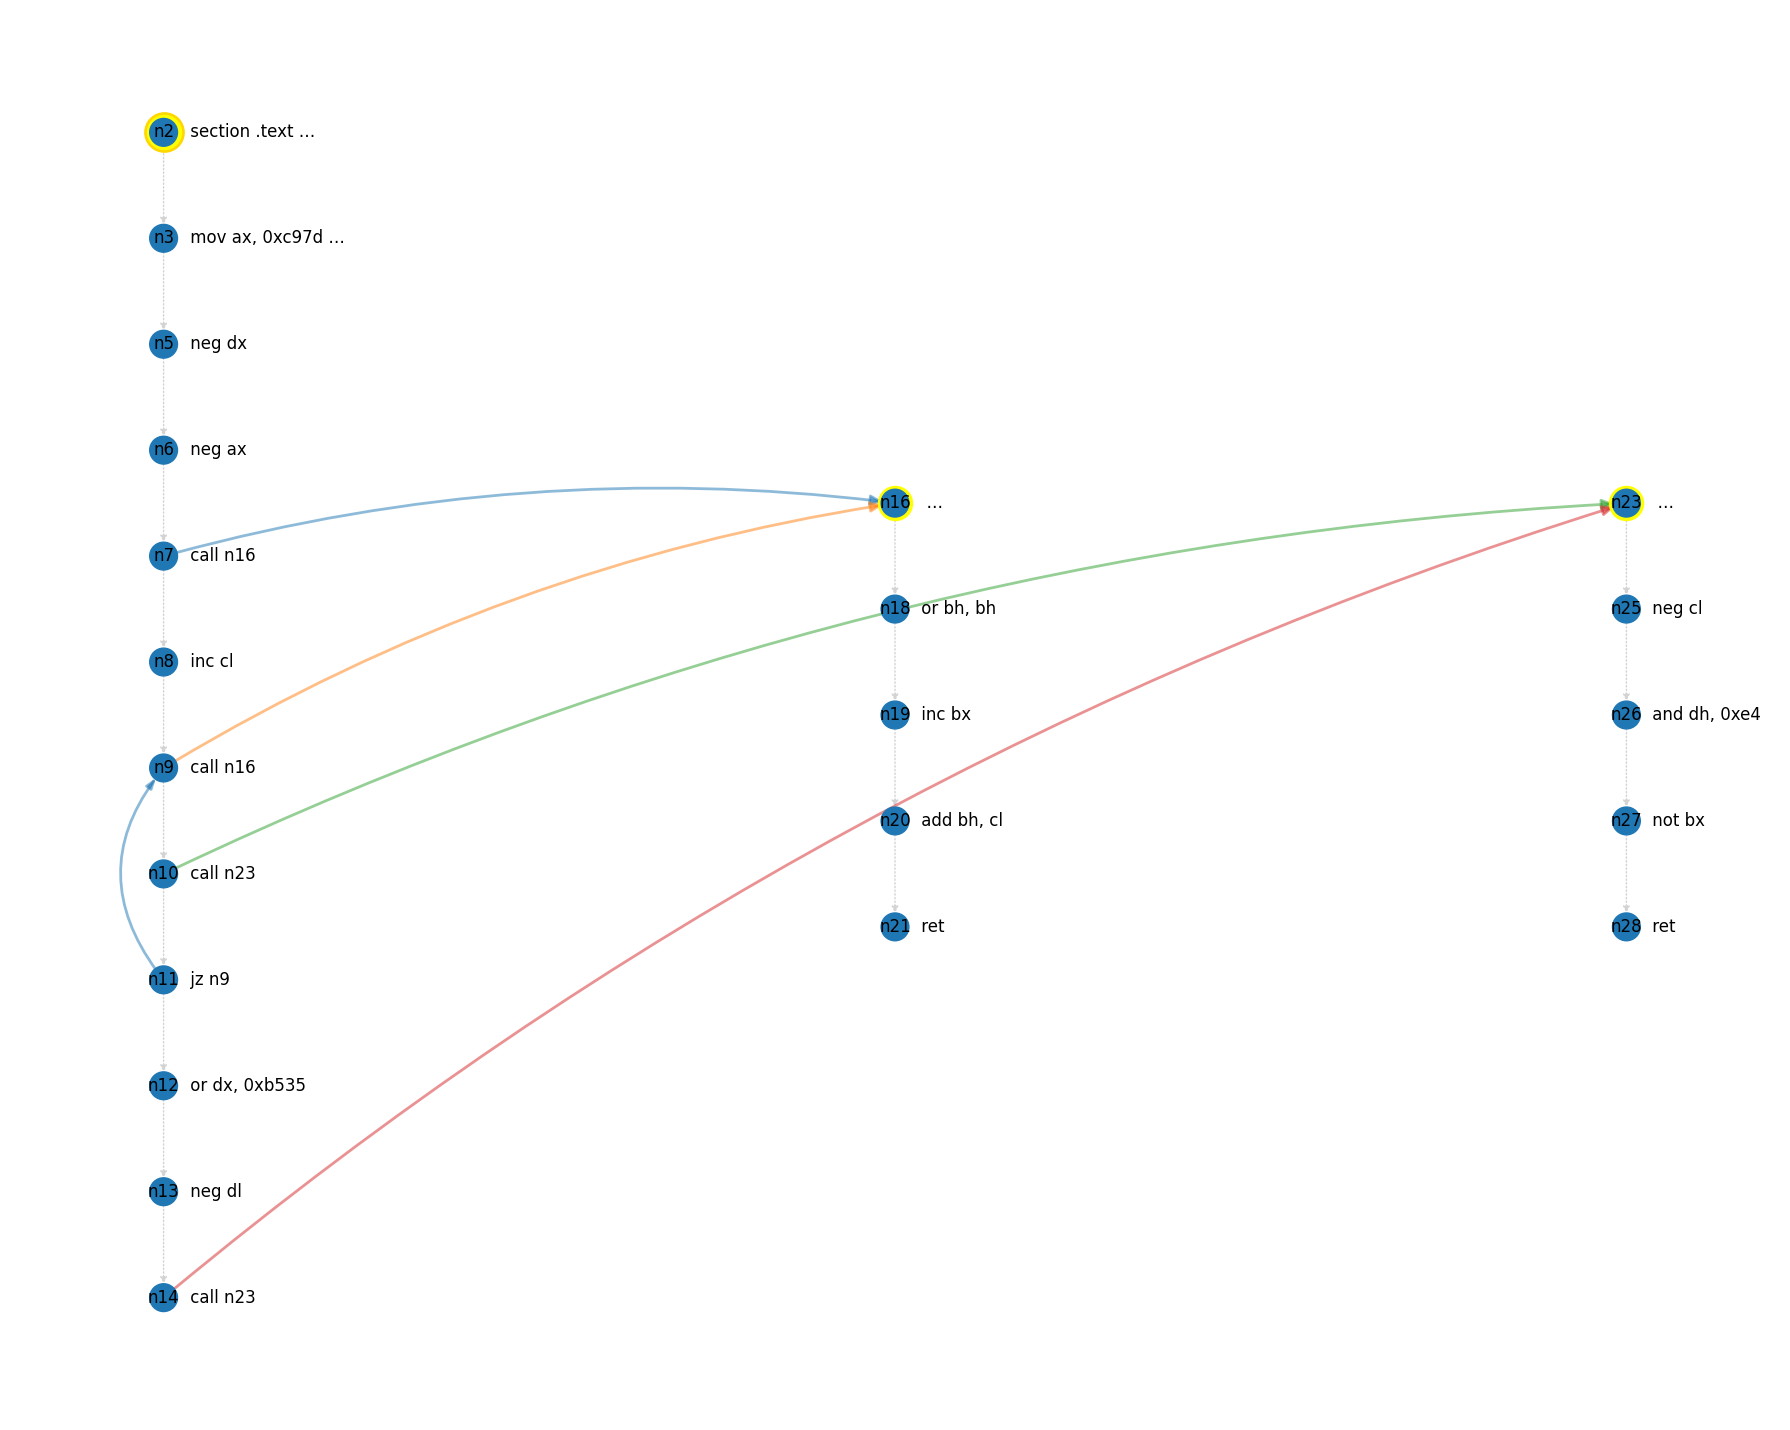

In [9]:
byron.f.as_forest(full_prog, seed=2)
byron.f.as_lgp(full_prog, seed=2)

### Final version

In [10]:
reg8 = byron.f.choice_parameter(['ah', 'bh', 'ch', 'dh', 'al', 'bl', 'cl', 'dl'])
reg16 = byron.f.choice_parameter(['ax', 'bx', 'cx', 'dx'])
int8 = byron.f.integer_parameter(0, 2 ** 8)
int16 = byron.f.integer_parameter(0, 2 ** 16)

opcodes2 = byron.f.choice_parameter(['mov', 'add', 'sub', 'or', 'and'])
opcodes1 = byron.f.choice_parameter(['not', 'neg', 'inc', 'dec'])
opcodes0 = byron.f.choice_parameter(['nop', 'hlt'])

inst8rr = byron.f.macro("{op} {r1}, {r2}", op=opcodes2, r1=reg8, r2=reg8)
inst8ri = byron.f.macro("{op} {r}, {i:#x}", op=opcodes2, r=reg8, i=int8)
inst8r = byron.f.macro("{op} {r}", op=opcodes1, r=reg8)
inst16rr = byron.f.macro("{op} {r1}, {r2}", op=opcodes2, r1=reg16, r2=reg16)
inst16ri = byron.f.macro("{op} {r}, {i:#x}", op=opcodes2, r=reg16, i=int16)
inst16r = byron.f.macro("{op} {r}", op=opcodes1, r=reg16)

tests = byron.f.choice_parameter(['jz', 'jnz', 'jc', 'jnc', 'jo', 'jno', 'js', 'jns'])
branch = byron.f.macro("{test} {label}", test=tests, label=byron.f.local_reference())

main_prologue = "section .text\nglobal _start\n_start:"
init = byron.f.macro("mov ax, {v:#x}\nmov bx, {v:#x}\nmov cx, {v:#x}\nmov dx, {v:#x}", v=int16)

sub_entry = byron.f.macro("\nproc {_node} near", _label='')
sub_exit = byron.f.macro("ret")
sub_body = byron.f.bunch([inst16rr, inst16ri, inst16r, inst8rr, inst8ri, inst8r], (2, 10))
sub = byron.f.sequence([sub_entry, sub_body, sub_exit])

call = byron.f.macro("call {proc}", proc=byron.f.global_reference(sub, first_macro=True,
                                                                  creative_zeal=1))

main_body = byron.f.bunch([inst16rr, inst16ri, inst16r, inst8rr, inst8ri, inst8r, branch, call],
                          size=(5, 20))
full_prog = byron.f.sequence([main_prologue, init, main_body])

## Evolutionary Algorithm

### Fitness Function

In [11]:
@byron.fitness_function
def fitness(genotype):
    #print(genotype)
    return 0.0
    #raise Exception("Not implemented")

### Let's roll

Default logging level is `DEBUG` in notebooks and `INFO` in scripts. It is possible to change it with `byron.logger.setLevel(logging.INFO)`.

In [13]:
evaluator = byron.evaluator.PythonEvaluator(fitness, strip_phenotypes=True)
population = byron.ea.vanilla_ea(full_prog, evaluator, max_generation=5_000, lambda_=20, mu=30)

INFO ▷ VanillaEA: 🍦 [b]VanillaEA started[/] ┈ ⌛ 0:00:00.00 [t] / 🕙️  0:00:00.00 [byron]
DEBUG ▷ Individual: Fitness of 𝐢70/random_individual() is 0Ƒ
DEBUG ▷ Individual: Fitness of 𝐢71/random_individual() is 0Ƒ
DEBUG ▷ Individual: Fitness of 𝐢72/random_individual() is 0Ƒ
DEBUG ▷ Individual: Fitness of 𝐢73/random_individual() is 0Ƒ
DEBUG ▷ Individual: Fitness of 𝐢74/random_individual() is 0Ƒ
DEBUG ▷ Individual: Fitness of 𝐢75/random_individual() is 0Ƒ
DEBUG ▷ Individual: Fitness of 𝐢76/random_individual() is 0Ƒ
DEBUG ▷ Individual: Fitness of 𝐢77/random_individual() is 0Ƒ
DEBUG ▷ Individual: Fitness of 𝐢78/random_individual() is 0Ƒ
DEBUG ▷ Individual: Fitness of 𝐢79/random_individual() is 0Ƒ
DEBUG ▷ Individual: Fitness of 𝐢80/random_individual() is 0Ƒ
DEBUG ▷ Individual: Fitness of 𝐢81/random_individual() is 0Ƒ
DEBUG ▷ Individual: Fitness of 𝐢82/random_individual() is 0Ƒ
DEBUG ▷ Individual: Fitness of 𝐢83/random_individual() is 0Ƒ
DEBUG ▷ Individual: Fitness of 𝐢84/random_individual() is 

AssertionError: SystemError (paranoia check): Incorrect structure. Graph is not weakly connected.

In [ ]:
byron.logger.info("Hey")